In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [79]:
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from pgmpy.estimators import PC
import pingouin
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS, PooledOLS
from itertools import combinations
from linearmodels.panel import compare
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import geopandas
from statsmodels.iolib.summary2 import summary_col
from abiFunctions import get_residuals, build_skeleton, graph_undirected_DAG
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [4]:
from abiFunctions import import_geo_data

In [5]:
from abbeyFunctions import graph_DAG, create_cluster_dags, determine_p_value, graph_DAG_cluster, get_edges_dict, get_col_shared_edges, get_row_shared_edges, plot_shared_edges, plot_shared_col_edges, plot_shared_row_edges, hausman_test

In [6]:
from abiFunctions import calculate_aic, calculate_bic, calculate_hqic, get_model_summary, plot_residuals_vs_predicted, plot_residuals_vs_independent_vars, forward_stepwise_selection, backward_stepwise_selection, plot_residuals_vs_dependent_var, calculate_avg_squared_correlations

Create the geographical data to extract population for each county

In [ ]:
fips_name = "FIPS"
map_data = import_geo_data(
    filename = "countiesWithStatesAndPopulation.shp",
    index_col = "Date", FIPS_name= fips_name)

Import nominal data

In [8]:
ai_data_nominal = pd.read_csv('nominal_data.csv')

ai_data_nominal = ai_data_nominal.rename(columns={'FIPS_y': 'FIPS'})

ai_data_nominal = ai_data_nominal.set_index(['FIPS', 'TimePeriod'])

Here we create a dictionary to store the different data formats for the nominal data

In [9]:
exclude_vars = ['M4 I', 'unem']  # List of variables to exclude

# Create a dictionary to store the dataframes
ai_dct = {"logged": ai_data_nominal.copy(),
          "rates": ai_data_nominal.copy(),
         "percent rates": ai_data_nominal.copy()}

        
for col in ai_dct['logged'].columns:
    if col not in exclude_vars:
        ai_dct["logged"][col] = np.log(ai_data_nominal[col]).replace([np.inf, -np.inf], np.nan)


# Calculate rate of change (differences of log-transformed values)
for col in ai_dct['rates'].columns:
    if col not in exclude_vars:
        ai_dct["rates"][col] = ai_dct["logged"].groupby('FIPS')[col].diff().dropna()
                
        
        # Calculate percent rate of change
for col in ai_dct['percent rates'].columns:
    #if col not in exclude_vars:
        ai_dct["percent rates"][col] = ai_dct["rates"].groupby('FIPS')[col].diff().dropna()


Import real data

In [10]:
real_df = pd.read_csv('real_data.csv')

real_df = real_df.rename(columns={'FIPS_y': 'FIPS',
                                 'RM4_':'RM4',
                                 'All ':'All'})

real_df = real_df.set_index(['FIPS', 'TimePeriod'])

Here we create a dictionary to store the different formats for the real data

In [11]:
exclude_vars = ['RM4I', 'unem']  # List of variables to exclude

# Create a dictionary to store the dataframes
ai_dct_real = {"logged": real_df.copy(),
          "rates": real_df.copy(),
         "percent rates": real_df.copy()}

        
for col in ai_dct_real['logged'].columns:
    if col not in exclude_vars:
        ai_dct_real["logged"][col] = np.log(real_df[col]).replace([np.inf, -np.inf], np.nan)


# Calculate rate of change (differences of log-transformed values)
for col in ai_dct_real['rates'].columns:
    if col not in exclude_vars:
        ai_dct_real["rates"][col] = ai_dct_real["logged"].groupby('FIPS')[col].diff().dropna()
                
        
        # Calculate percent rate of change
for col in ai_dct_real['percent rates'].columns:
    #if col not in exclude_vars:
        ai_dct_real["percent rates"][col] = ai_dct_real["rates"].groupby('FIPS')[col].diff().dropna()


In [12]:
diff_nominal = ai_dct['percent rates']

diff_nom = diff_nominal.copy()

diff_nominal.drop(columns=['All ', 'Neig'], inplace=True)

In [13]:
diff_nominal = diff_nominal.rename(columns={'M4_y': 'M4', 'M4 I':'M4I'}).dropna()

In [14]:
diff_nominal_clusters = pd.read_csv('diff_nominal_kml3d.csv')

diff_nominal_clusters = diff_nominal_clusters.rename(columns={'FIPS_y': 'FIPS'})

In [15]:
full_df_cluster = pd.merge(diff_nominal, diff_nominal_clusters[['FIPS', 'clusters']], on='FIPS', how='left')

full_df_cluster = full_df_cluster.dropna()

full_df_cluster = full_df_cluster.set_index(['FIPS'])

In [16]:
cluster_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4}

In [17]:
full_df_cluster['clusters'].replace(cluster_mapping, inplace=True)

In [18]:
diff_nominal = diff_nominal.reset_index()

In [19]:
full_df_cluster = full_df_cluster.reset_index()

In [20]:
full_df_cluster = pd.merge(diff_nominal, full_df_cluster[['FIPS', 'clusters']], on='FIPS', how='left')

In [21]:
# Drop exactly duplicated rows
full_df_cluster = full_df_cluster.drop_duplicates()

full_df_cluster = full_df_cluster.set_index(['FIPS', 'TimePeriod'])

In [22]:
nominal_differenced_rate_with_all_variables = diff_nominal.dropna().set_index(['FIPS', 'TimePeriod'])

# Create a dictionary to store the DataFrames
nominal_differenced_rates = {}

nominal_differenced_rates['including_all_variables'] = nominal_differenced_rate_with_all_variables

nominal_differenced_rates['without_monetary_variables'] = nominal_differenced_rate_with_all_variables.drop(columns=['M4', 'M4I'])

nominal_differenced_rates['without_unemployment_variable'] = nominal_differenced_rate_with_all_variables.drop(columns=['unem'])

Here we plot the full DAGs

  0%|          | 0/4 [00:00<?, ?it/s]

('unem', 'Mini') []
keep control: Mini
('unem', 'M4I') ['Mini']
keep control: unem
('Mini', 'M4I') ['unem']
('M4', 'unem') []
keep control: Agri
('Util', 'M4') ['Agri']
keep control: Util
('Agri', 'M4') ['Util']


  0%|          | 0/2 [00:00<?, ?it/s]

keep control: Agri
keep control: Mini
('Util', 'unem') ['Agri', 'Mini']
keep control: Util
keep control: Agri
('Mini', 'unem') ['Util', 'Agri']
keep control: Util
keep control: Mini
('Agri', 'unem') ['Util', 'Mini']


  0%|          | 0/3 [00:00<?, ?it/s]

keep control: Agri
keep control: M4I
keep control: Mini
('Util', 'M4') ['Agri', 'M4I', 'Mini']
keep control: Util
keep control: Agri
keep control: Mini
('M4I', 'M4') ['Util', 'Agri', 'Mini']
('M4I', 'Mini') []
keep control: Util
keep control: M4I
keep control: Mini
('Agri', 'M4') ['Util', 'M4I', 'Mini']
keep control: Util
keep control: Agri
keep control: M4I
('Mini', 'M4') ['Util', 'Agri', 'M4I']
('Mini', 'M4I') []


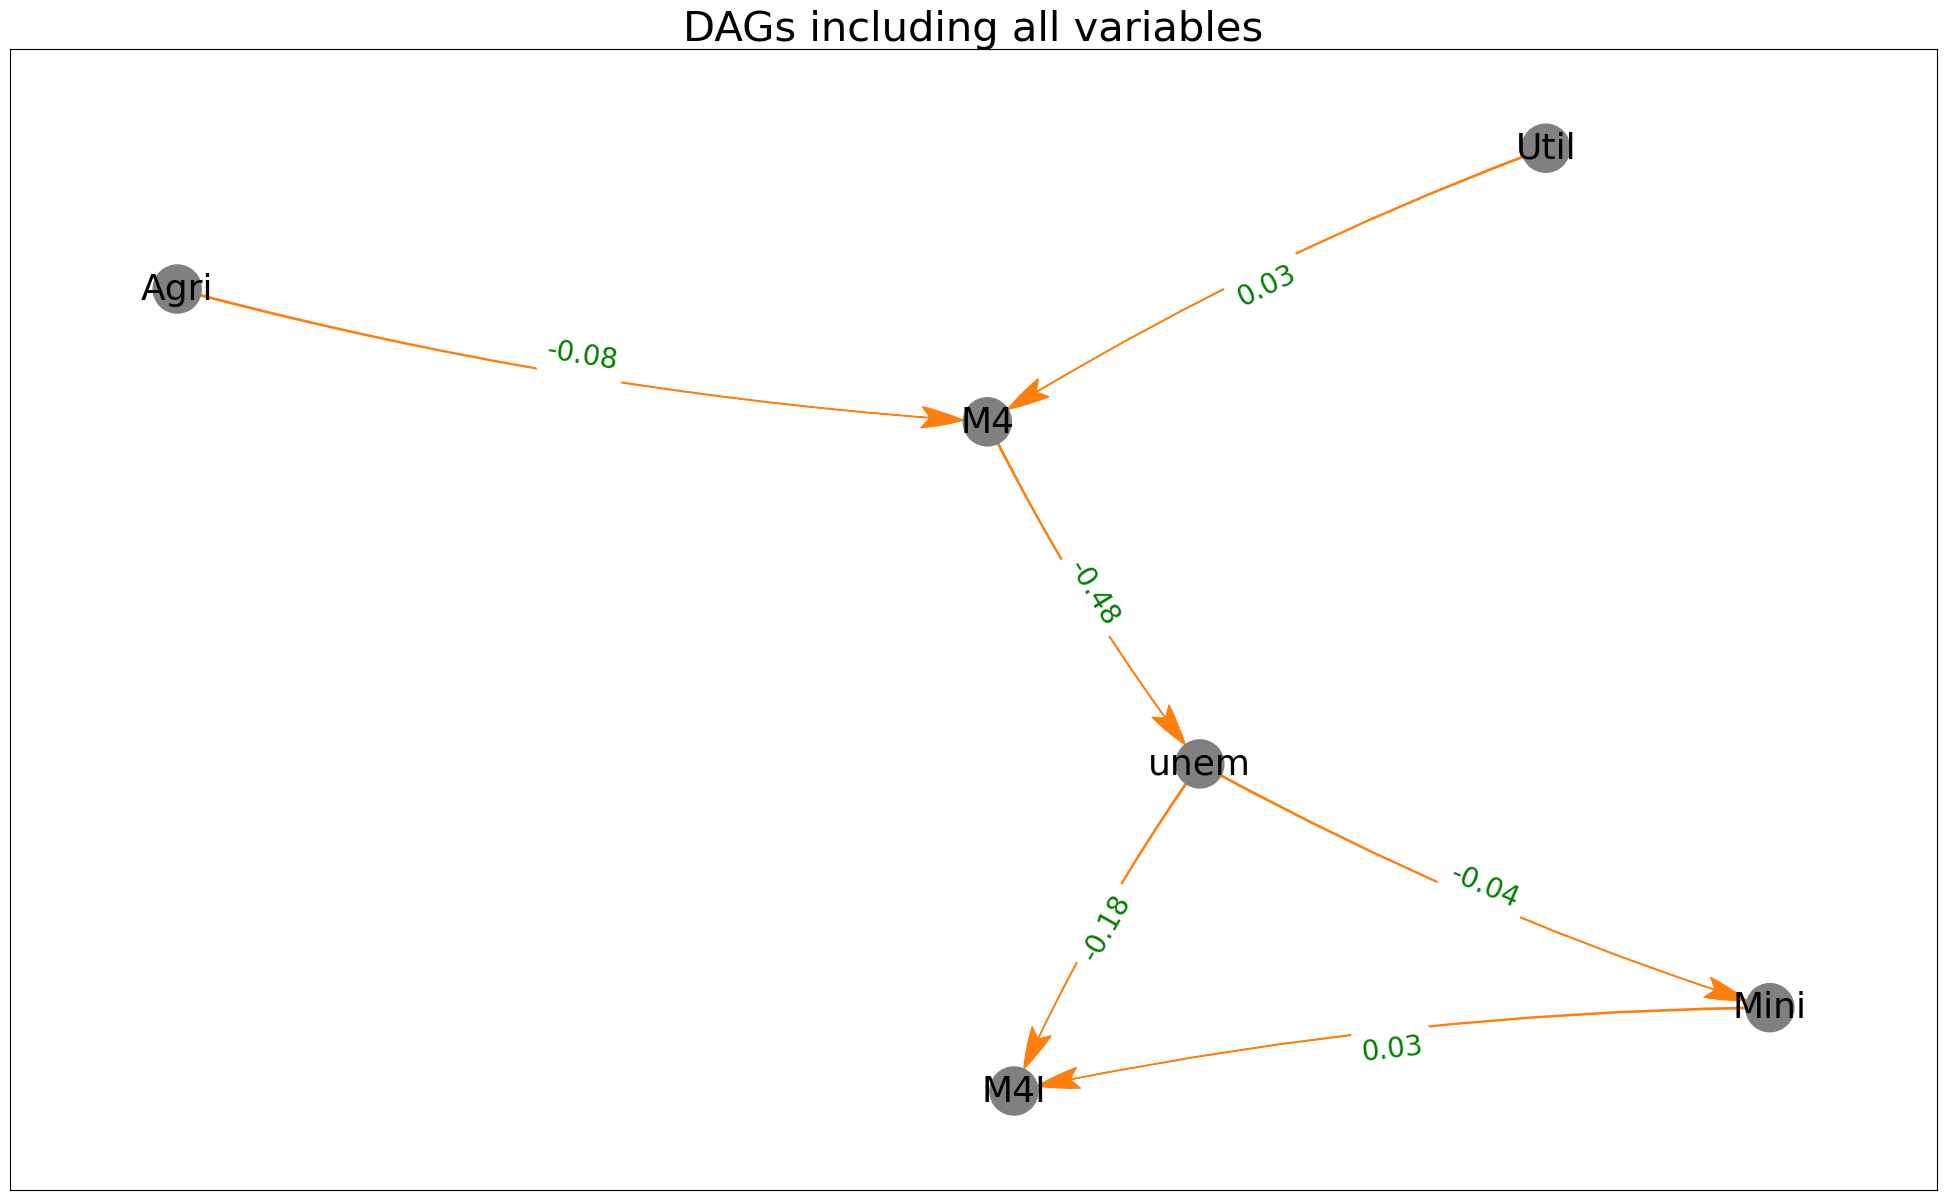

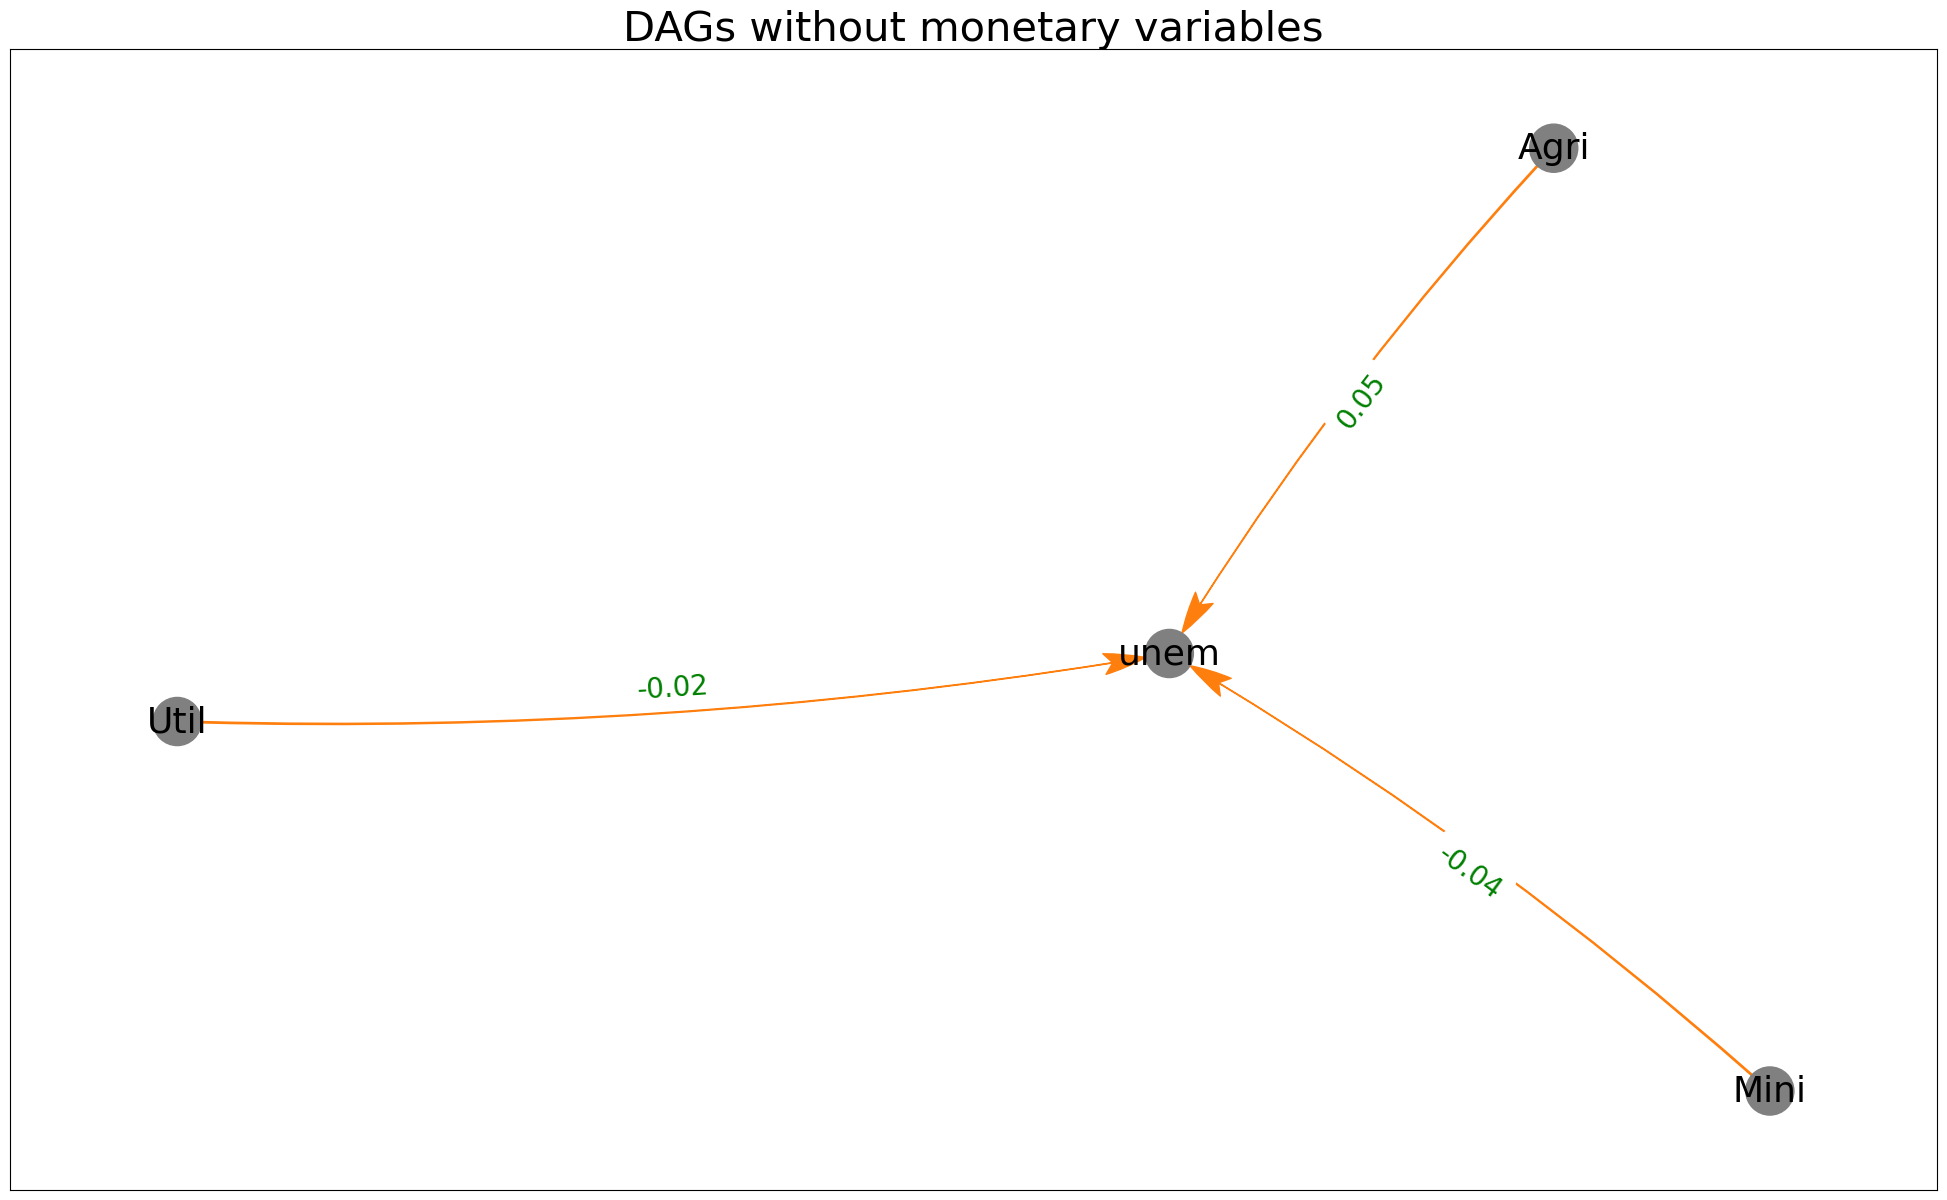

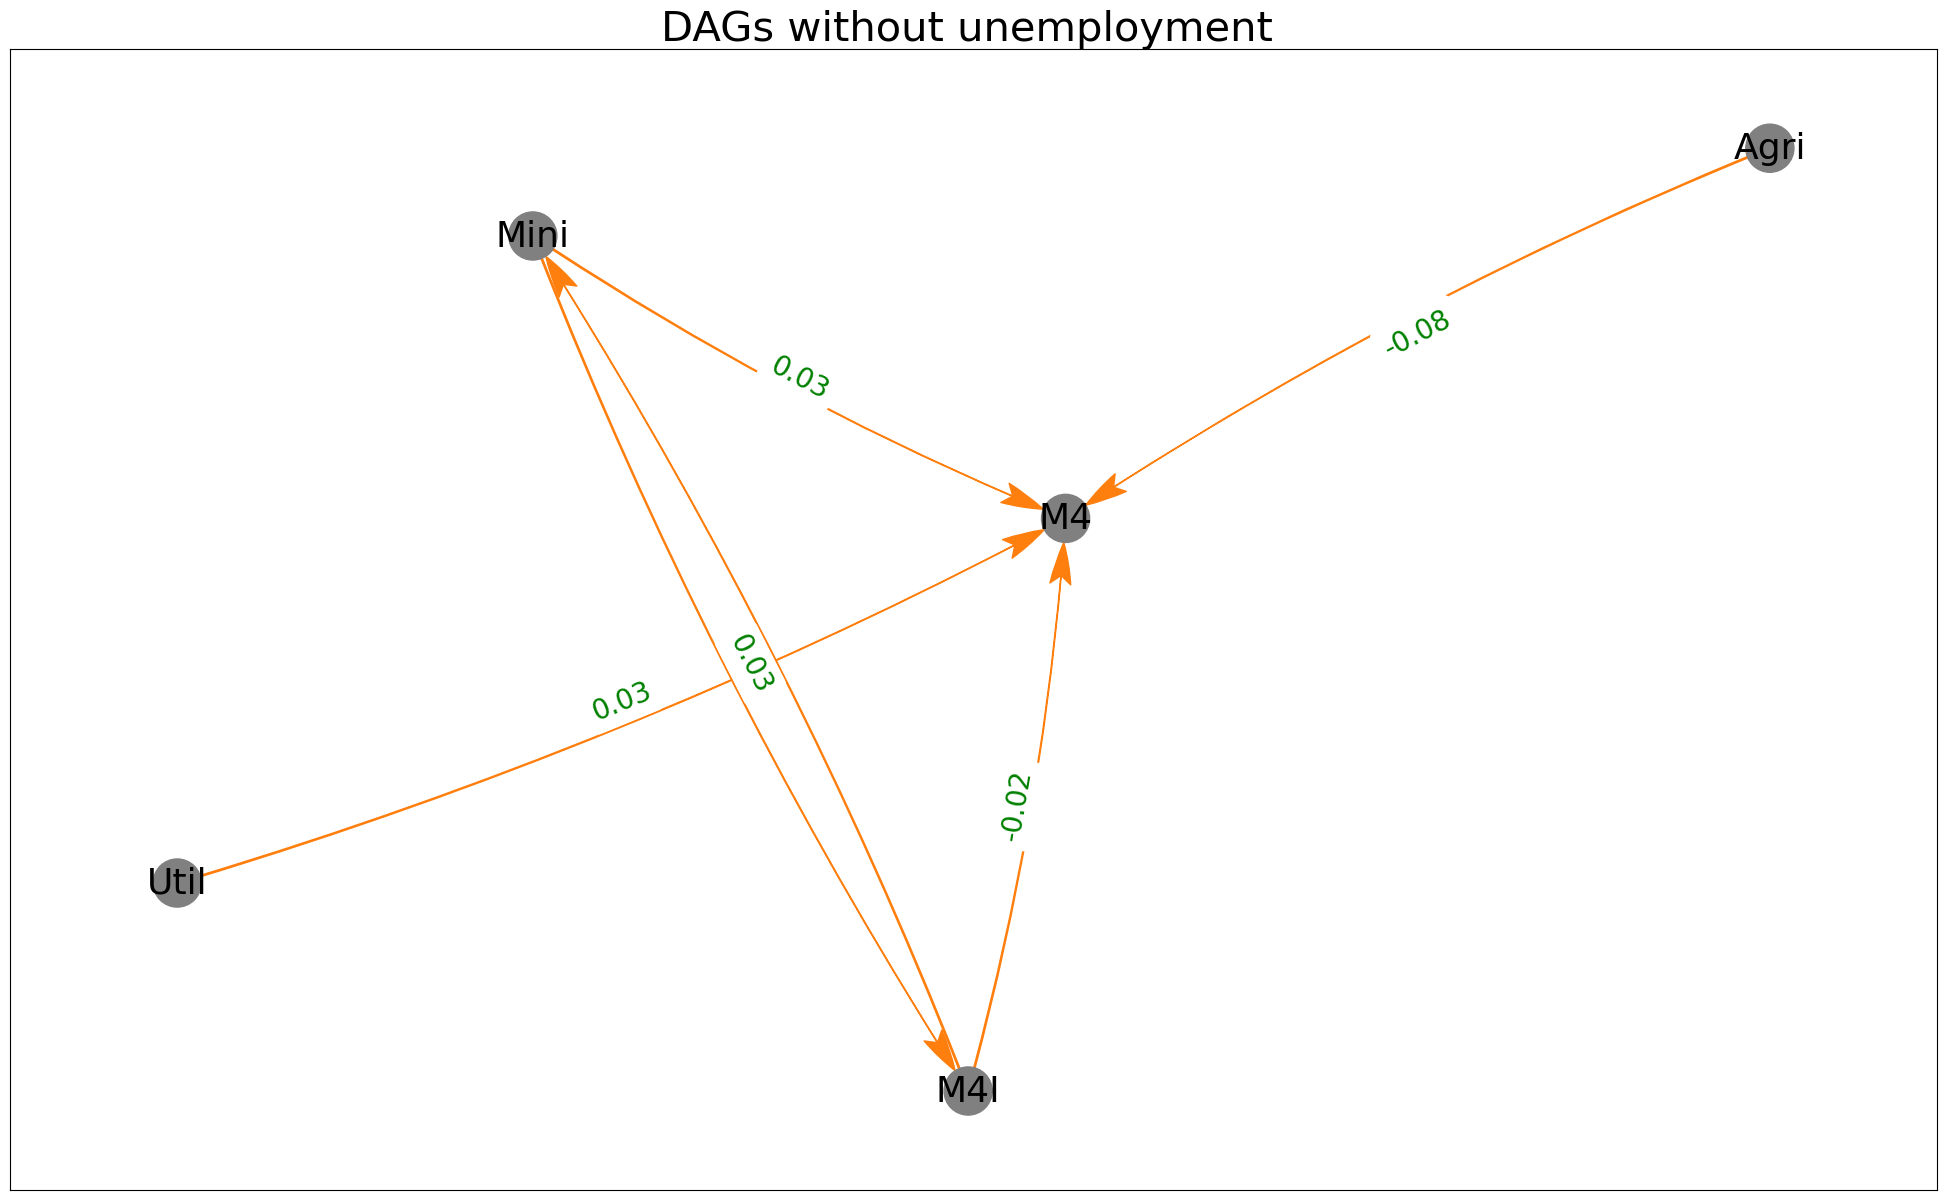

In [23]:
# Initialize a PdfPages object to save the plots in a PDF
#pp = PdfPages("DAGs_nominal")

title = ['DAGs including all variables',
        'DAGs without monetary variables',
        'DAGs without unemployment ']

# Plot DAGs for each dataframe
for i, key in enumerate(['including_all_variables', 
                         'without_monetary_variables', 
                         'without_unemployment_variable']):
    plot_df = nominal_differenced_rates[key]
    c = PC(plot_df)
    max_cond_vars = len(plot_df.keys()) - 2
    model = c.estimate(return_type='pdag', variant='orig', significance_level=0.01,
                       max_cond_vars=max_cond_vars, ci_test='pearsonr')
    edges = model.edges

    # Plot the DAG
    graph_DAG(edges, plot_df, title=title[i])
    
    # Save the plot to the PDF
#    pp.savefig()

# Close the PdfPages object
#pp.close()


In [24]:
df = full_df_cluster.reset_index()

df = df.reset_index().set_index(['FIPS', 'TimePeriod'])

In [25]:
# Convert 'clusters' column to dummy variables, dropping the first category
df = pd.get_dummies(df, columns=['clusters'], drop_first=True)

# List all the dummy variables created
cluster_dummies = [col for col in df.columns if col.startswith('clusters_')]

Now we model the pooled regressions and compare them

In [26]:
# Define your models
models = {
    'pooled regression with clusters': (['M4', 'M4I', 'Agri', 'Util', 'Mini'] + cluster_dummies, False, False),
    'pooled regression without clusters': (['M4', 'M4I', 'Agri', 'Util', 'Mini'], False, False)
}

# Fit the models and store results
results = {}
for name, (independent_vars, entity_effects, time_effects) in models.items():
    model = PooledOLS(df['unem'], df[independent_vars])
    results[name] = model.fit(cov_type='clustered', cluster_entity=True)

# Print the results
for name, result in results.items():
    print(f'== {name} ==')
    print(result)
    print()

== pooled regression with clusters ==
                          PooledOLS Estimation Summary                          
Dep. Variable:                   unem   R-squared:                        0.2727
Estimator:                  PooledOLS   R-squared (Between):              0.3397
No. Observations:               26823   R-squared (Within):               0.2722
Date:                Wed, Jun 12 2024   R-squared (Overall):              0.2727
Time:                        13:24:30   Log-likelihood                -4.313e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1257.0
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                 F(8,26815)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):          

In [27]:
comparison = compare(results)
comparison

,pooled regression with clusters,pooled regression without clusters
Dep. Variable,unem,unem
Estimator,PooledOLS,PooledOLS
No. Observations,26823,26823
Cov. Est.,Clustered,Clustered
R-squared,0.2727,0.2710
R-Squared (Within),0.2722,0.2722
R-Squared (Between),0.3397,0.3249
R-Squared (Overall),0.2727,0.2710
F-statistic,1257.0,1994.3
P-value (F-stat),0.0000,0.0000


### Weighted Least Squares

Now we model the different WLS regressions with different weights and compare their results

In [29]:
# real_data = ai_dct_real["percent rates"].reset_index()

In [30]:
data = df.copy().reset_index().dropna()
map_data = map_data.reset_index()

merged_df = data.merge(map_data[['FIPS', 'Population']], on='FIPS', how='left')

In [31]:
real_data = ai_dct_real["percent rates"].dropna().reset_index()

In [32]:
# real_data = real_df.reset_index()

In [33]:
merged_df = data.merge(map_data[['FIPS', 'Population']], on='FIPS', how='left')

merged_df = merged_df.dropna()

merged_data = pd.merge(merged_df, real_data[['FIPS', 'TimePeriod', 'All']], on=['FIPS', 'TimePeriod'], how='left')

merged_data.rename(columns={'All':'Real_gdp'}, inplace=True)

In [89]:
data = merged_data.copy()

# 1. Check for NaNs and Infinite values in the relevant columns
columns_to_check = ['FIPS', 'TimePeriod', 'index', 'Agri', 'Mini', 'Util', 'M4', 'M4I',
                    'unem', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0', 'Population', 'Real_gdp']
data = data[columns_to_check]

# Here we drop rows with NaNs or infinite values
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# 2. Now we calculate the variances of total real gdp for each 'FIPS' group
county_gdp = data.groupby('FIPS')['Real_gdp'].var()
county_unem = data.groupby('FIPS')['unem'].var()

# 3. Next we create the weights based on the inverse of these variances
data['weight'] = data['FIPS'].map(lambda x: 1 / county_gdp[x])
data['weight_unem'] = data['FIPS'].map(lambda x: 1 / county_unem[x])

# Ensuring that the weights column has no NaNs or infinite values
data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['weight'])
data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['weight_unem'])

# Defining the dependent variable
y = data['unem']

# 4. Defining the independent variables
X_with_clusters = data[['Agri', 'Mini', 'Util', 'M4', 'M4I', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0']]
X_without_clusters = data[['Agri', 'Mini', 'Util', 'M4', 'M4I']]

# 5. Checking for multicollinearity using VIF
vif_data_with_clusters = pd.DataFrame()
vif_data_with_clusters["feature"] = X_with_clusters.columns
vif_data_with_clusters["VIF"] = [variance_inflation_factor(X_with_clusters.values, i) for i in range(len(X_with_clusters.columns))]
# print("VIF Data with Clusters:\n", vif_data_with_clusters)

vif_data_without_clusters = pd.DataFrame()
vif_data_without_clusters["feature"] = X_without_clusters.columns
vif_data_without_clusters["VIF"] = [variance_inflation_factor(X_without_clusters.values, i) for i in range(len(X_without_clusters.columns))]
# print("VIF Data without Clusters:\n", vif_data_without_clusters)

# 6. Fit the WLS models

# Define the weight for the first model (using total gdp)
weights = data['weight']
weight_unem = data['weight_unem']

try:
    # Model with clusters
    model_with_clusters = sm.WLS(y, X_with_clusters, weights=weights)
    results_with_clusters = model_with_clusters.fit()
    
    # Model with clusters and unemployment as weight
    model_with_clusters_unem = sm.WLS(y, X_with_clusters, weights=weight_unem)
    results_with_clusters_unem = model_with_clusters_unem.fit()
    
    # Model without clusters
    model_without_clusters = sm.WLS(y, X_without_clusters, weights=weights)
    results_without_clusters = model_without_clusters.fit()
    
    # Model without clusters and unemployment as weight
    model_without_clusters_unem = sm.WLS(y, X_without_clusters, weights=weight_unem)
    results_without_clusters_unem = model_without_clusters_unem.fit()
    

except np.linalg.LinAlgError as e:
    print(f"Linear Algebra error: {e}")
except sm.tools.sm_exceptions.MissingDataError as e:
    print(f"Missing data error: {e}")

# Now for the models using population as weights

# Define the dependent variable
y_pop = data['unem']

# Define the independent variables with clusters
x_with_clusters_pop = data[['Agri', 'Mini', 'Util', 'M4', 'M4I', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0']]
# Define the independent variables without clusters
x_without_clusters_pop = data[['Agri', 'Mini', 'Util', 'M4', 'M4I']]

# Define the weights (using the population)
weights_pop = data['Population']

# Fit the WLS model with clusters
model_with_clusters_pop = sm.WLS(y_pop, x_with_clusters_pop, weights=weights_pop)
results_with_clusters_pop = model_with_clusters_pop.fit()

# Fit the WLS model without clusters
model_without_clusters_pop = sm.WLS(y_pop, x_without_clusters_pop, weights=weights_pop)
results_without_clusters_pop = model_without_clusters_pop.fit()

# Compare the results side by side
results_table = summary_col([results_with_clusters,
                             results_without_clusters,
                             results_with_clusters_pop,
                             results_without_clusters_pop,
                             results_with_clusters_unem,
                             results_without_clusters_unem], 
                            model_names=['WLS(GDP) with Clusters', 'WLS(GDP) without Clusters', 
                                         'WLS(Pop) with Clusters', 'WLS(Pop) without Clusters',
                                         'WLS(unem) with Clusters', 'WLS(unem) without Clusters'],
                            stars=True, 
                            float_format='%0.4f',
                            info_dict={'N': lambda x: f"{int(x.nobs)}" 
#                                        ,'R2': lambda x: f"{x.rsquared:.4f}"
                                      })

# Compare the results side by side
results_table


,WLS(GDP) with Clusters,WLS(GDP) without Clusters,WLS(Pop) with Clusters,WLS(Pop) without Clusters,WLS(unem) with Clusters,WLS(unem) without Clusters
Agri,-0.0305***,-0.0324***,0.0262***,0.0259***,0.0323***,-2.5279***
,(0.0055),(0.0055),(0.0087),(0.0087),(0.0010),(0.0025)
M4,-8.8699***,-8.7899***,-15.8005***,-15.8257***,-3.8938***,289.9317***
,(0.1078),(0.1055),(0.1555),(0.1555),(0.1177),(0.2503)
M4I,-30.7426***,-31.0880***,-49.2609***,-49.0167***,0.0201***,11.4684***
,(0.7730),(0.7707),(1.1141),(1.1138),(0.0007),(0.0097)
Mini,-0.0389***,-0.0431***,-0.1155***,-0.1138***,-0.0130*,-2.2939***
,(0.0096),(0.0096),(0.0140),(0.0140),(0.0076),(0.1263)
R-squared,0.2709,0.2690,0.3596,0.3588,1.0000,1.0000
R-squared Adj.,0.2706,0.2689,0.3594,0.3586,1.0000,1.0000


### Determining the models that predicts best

Here we use the average mean squares errors for each of the models fitted to determine which model predicts best by the smallest MSE. We include the pooled regressions and the weighted least square regressions.

In [67]:
data = merged_data.copy()

# Checking for NaNs and Infinite values in the relevant columns
columns_to_check = ['FIPS', 'TimePeriod', 'index', 'Agri', 'Mini', 'Util', 'M4', 'M4I',
                    'unem', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0', 'Population', 'Real_gdp']
data = data[columns_to_check]

# Dropping rows with NaNs or infinite values
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Calculating the variances of total real GDP for each 'FIPS' group and for unem
county_gdp = data.groupby('FIPS')['Real_gdp'].var()
county_unem = data.groupby('FIPS')['unem'].var()

# Creating the weights based on the inverse of these variances
data['weight'] = data['FIPS'].map(lambda x: 1 / county_gdp[x])
data['weight_unem'] = data['FIPS'].map(lambda x: 1 / county_unem[x])

# Ensuring that the weights column has no NaNs or infinite values
data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['weight'])
data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['weight_unem'])

# Defining the dependent variable and independent variables for the models
y = data['unem']
X_with_clusters = data[['Agri', 'Mini', 'Util', 'M4', 'M4I', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0']]
X_without_clusters = data[['Agri', 'Mini', 'Util', 'M4', 'M4I']]

# Checking for multicollinearity using VIF
vif_data_with_clusters = pd.DataFrame()
vif_data_with_clusters["feature"] = X_with_clusters.columns
vif_data_with_clusters["VIF"] = [variance_inflation_factor(X_with_clusters.values, i) for i in range(len(X_with_clusters.columns))]

vif_data_without_clusters = pd.DataFrame()
vif_data_without_clusters["feature"] = X_without_clusters.columns
vif_data_without_clusters["VIF"] = [variance_inflation_factor(X_without_clusters.values, i) for i in range(len(X_without_clusters.columns))]

# Defining the weights for the models
weights = data['weight']
weights_pop = data['Population']
weights_unem = data['weight_unem']

# Setting up k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Placeholder lists to store performance metrics
mse_with_clusters = []
mse_without_clusters = []
mse_with_clusters_pop = []
mse_without_clusters_pop = []
mse_with_clusters_pooled = []
mse_without_clusters_pooled = []
mse_with_clusters_unem = []
mse_without_clusters_unem = []


# Performing k-fold cross-validation
for train_index, test_index in kf.split(data):
    # Split the data into training and validation sets
    X_train_with_clusters, X_test_with_clusters = X_with_clusters.iloc[train_index], X_with_clusters.iloc[test_index]
    X_train_without_clusters, X_test_without_clusters = X_without_clusters.iloc[train_index], X_without_clusters.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    weights_train, weights_test = weights.iloc[train_index], weights.iloc[test_index]
    weights_pop_train, weights_pop_test = weights_pop.iloc[train_index], weights_pop.iloc[test_index]
    weights_unem_train, weights_unem_test = weights_unem.iloc[train_index], weights_unem.iloc[test_index]
    
    # Fit the WLS models with the total GDP weights
    model_with_clusters = sm.WLS(y_train, X_train_with_clusters, weights=weights_train).fit()
    model_without_clusters = sm.WLS(y_train, X_train_without_clusters, weights=weights_train).fit()
    
    # Fit the WLS models with the population weights
    model_with_clusters_pop = sm.WLS(y_train, X_train_with_clusters, weights=weights_pop_train).fit()
    model_without_clusters_pop = sm.WLS(y_train, X_train_without_clusters, weights=weights_pop_train).fit()


    # Fit the WLS models with the unemployment weights
    model_with_clusters_unem = sm.WLS(y_train, X_train_with_clusters, weights=weights_unem_train).fit()
    model_without_clusters_unem = sm.WLS(y_train, X_train_without_clusters, weights=weights_unem_train).fit()    
    
    
    # Convert y_train and y_test to DataFrame and set 2-level MultiIndex
    y_train_pooled = y_train.to_frame().set_index([data.iloc[train_index].index, data.iloc[train_index]['TimePeriod']])
    y_test_pooled = y_test.to_frame().set_index([data.iloc[test_index].index, data.iloc[test_index]['TimePeriod']])
    
    # Set 2-level MultiIndex for X_train and X_test
    X_train_with_clusters_pooled = X_train_with_clusters.set_index([data.iloc[train_index].index, data.iloc[train_index]['TimePeriod']])
    X_train_without_clusters_pooled = X_train_without_clusters.set_index([data.iloc[train_index].index, data.iloc[train_index]['TimePeriod']])
    
    X_test_with_clusters_pooled = X_test_with_clusters.set_index([data.iloc[test_index].index, data.iloc[test_index]['TimePeriod']])
    X_test_without_clusters_pooled = X_test_without_clusters.set_index([data.iloc[test_index].index, data.iloc[test_index]['TimePeriod']])
    
    # Fitting the pooled OLS models
    pooled_with_clusters = PooledOLS(y_train_pooled, sm.add_constant(X_train_with_clusters_pooled)).fit()
    pooled_without_clusters = PooledOLS(y_train_pooled, sm.add_constant(X_train_without_clusters_pooled)).fit()
    
    # Making predictions on the validation set
    y_pred_with_clusters = model_with_clusters.predict(X_test_with_clusters)
    y_pred_without_clusters = model_without_clusters.predict(X_test_without_clusters)
    y_pred_with_clusters_pop = model_with_clusters_pop.predict(X_test_with_clusters)
    y_pred_without_clusters_pop = model_without_clusters_pop.predict(X_test_without_clusters)
    y_pred_with_clusters_pooled = pooled_with_clusters.predict(sm.add_constant(X_test_with_clusters_pooled))
    y_pred_without_clusters_pooled = pooled_without_clusters.predict(sm.add_constant(X_test_without_clusters_pooled))
    y_pred_with_clusters_unem = model_with_clusters_unem.predict(X_test_with_clusters)
    y_pred_without_clusters_unem = model_without_clusters_unem.predict(X_test_without_clusters)
    
    
    
    # Calculating the mean squared error for each model
    mse_with_clusters.append(mean_squared_error(y_test, y_pred_with_clusters))
    mse_without_clusters.append(mean_squared_error(y_test, y_pred_without_clusters))
    mse_with_clusters_pop.append(mean_squared_error(y_test, y_pred_with_clusters_pop))
    mse_without_clusters_pop.append(mean_squared_error(y_test, y_pred_without_clusters_pop))
    mse_with_clusters_pooled.append(mean_squared_error(y_test_pooled, y_pred_with_clusters_pooled))
    mse_without_clusters_pooled.append(mean_squared_error(y_test_pooled, y_pred_without_clusters_pooled))
    mse_with_clusters_unem.append(mean_squared_error(y_test, y_pred_with_clusters_unem))
    mse_without_clusters_unem.append(mean_squared_error(y_test, y_pred_without_clusters_unem))    
    

# Computing the average mean squared error across all folds
avg_mse_with_clusters = np.mean(mse_with_clusters)
avg_mse_without_clusters = np.mean(mse_without_clusters)
avg_mse_with_clusters_pop = np.mean(mse_with_clusters_pop)
avg_mse_without_clusters_pop = np.mean(mse_without_clusters_pop)
avg_mse_with_clusters_pooled = np.mean(mse_with_clusters_pooled)
avg_mse_without_clusters_pooled = np.mean(mse_without_clusters_pooled)
avg_mse_with_clusters_unem = np.mean(mse_with_clusters_unem)
avg_mse_without_clusters_unem = np.mean(mse_without_clusters_unem)

# Printing the average MSE for each model
print(f"Average MSE with clusters (total GDP weights): {avg_mse_with_clusters}")
print(f"Average MSE without clusters (total GDP weights): {avg_mse_without_clusters}")
print(f"Average MSE with clusters (population weights): {avg_mse_with_clusters_pop}")
print(f"Average MSE without clusters (population weights): {avg_mse_without_clusters_pop}")
print(f"Average MSE with clusters (pooled regression): {avg_mse_with_clusters_pooled}")
print(f"Average MSE without clusters (pooled regression): {avg_mse_without_clusters_pooled}")
print(f"Average MSE with clusters (unemployment weights): {avg_mse_with_clusters_unem}")
print(f"Average MSE without clusters (unemployment weights): {avg_mse_without_clusters_unem}")



Average MSE with clusters (total GDP weights): 1.0592870281506312
Average MSE without clusters (total GDP weights): 1.052292413506348
Average MSE with clusters (population weights): 1.1125755027233137
Average MSE without clusters (population weights): 1.1184638950734431
Average MSE with clusters (pooled regression): 1.0194486500293878
Average MSE without clusters (pooled regression): 1.0198552565522963
Average MSE with clusters (unemployment weights): 1.4098209631424732
Average MSE without clusters (unemployment weights): 205.78041887436703
